In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "layers": hp.choice('layers', [[100, 100, 100], [200, 200, 200], [500, 500, 500]]),
    "fc_dropout": hp.choice('fc_dropout', [0.1, 0.2, 0.5]),
    "use_bn": hp.choice('use_bn', [True, False])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1aed92a7d08>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x1aed9295388>,
 'lr': <hyperopt.pyll.base.Apply at 0x1aed9295ac8>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1aed929a108>,
 'patience': <hyperopt.pyll.base.Apply at 0x1ae43161c48>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1aed929a6c8>,
 'layers': <hyperopt.pyll.base.Apply at 0x1aed929e4c8>,
 'fc_dropout': <hyperopt.pyll.base.Apply at 0x1aed929ea48>,
 'use_bn': <hyperopt.pyll.base.Apply at 0x1aed929efc8>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

186

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = MLP
        k = {
            'layers': params['layers'],
            'fc_dropout': params['fc_dropout'],
            'use_bn': params['use_bn']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x000001AE3BEAB1F8>, 'patience': 5, 'time_steps': 60, 'use_bn': True}
MLP                                                                                                                    
  0%|                                                                           | 0/30 [00:29<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.754908,1.683862,0.377347,00:02
1,1.637329,1.544910,0.532889,00:01
2,1.473872,1.365554,0.600405,00:01
3,1.287624,1.175121,0.633319,00:01
4,1.130780,1.038341,0.652430,00:01
5,1.038999,0.963477,0.657449,00:01
6,0.981262,0.938836,0.660296,00:01
7,0.952547,0.927714,0.664688,00:01
8,0.931646,0.929499,0.665605,00:01
9,0.913947,0.905989,0.672892,00:01


No improvement since epoch 9: early stopping                                                                           
  0%|                                                                           | 0/30 [00:48<?, ?trial/s, best loss=?]

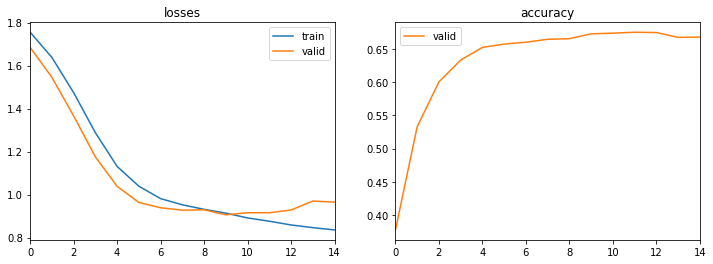

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 10, 'time_steps': 30, 'use_bn': False}
MLP                                                                                                                    
  3%|█▋                                               | 1/30 [01:16<23:31, 48.67s/trial, best loss: 0.9650856256484985]

epoch,train_loss,valid_loss,accuracy,time
0,1.400325,1.150615,0.664543,00:00
1,1.106942,1.040044,0.664543,00:00
2,1.021226,0.991721,0.664543,00:00
3,0.994472,0.975566,0.664543,00:00
4,0.977829,0.972227,0.662227,00:00
5,0.974879,0.971768,0.660489,00:00
6,0.967505,0.969107,0.660441,00:00
7,0.960859,0.969049,0.659958,00:00
8,0.964672,0.969228,0.659476,00:00
9,0.964501,0.969236,0.659476,00:00


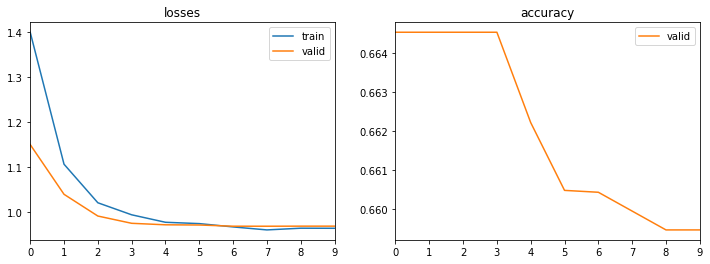

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 10, 'time_steps': 60, 'use_bn': False}
MLP                                                                                                                    
  7%|███▎                                             | 2/30 [01:53<21:05, 45.21s/trial, best loss: 0.9650856256484985]

epoch,train_loss,valid_loss,accuracy,time
0,1.319229,1.222185,0.664543,00:01
1,1.140883,1.123260,0.664543,00:01
2,1.081814,1.083774,0.664543,00:01
3,1.044223,1.053827,0.664543,00:01
4,1.014243,1.015566,0.664543,00:01
5,0.979965,0.979464,0.664591,00:01
6,0.957205,0.948236,0.658511,00:01
7,0.935293,0.934776,0.651899,00:01
8,0.920462,0.921058,0.655084,00:01
9,0.917580,0.936187,0.661985,00:01


No improvement since epoch 12: early stopping                                                                          
  7%|███▎                                             | 2/30 [02:27<21:05, 45.21s/trial, best loss: 0.9650856256484985]

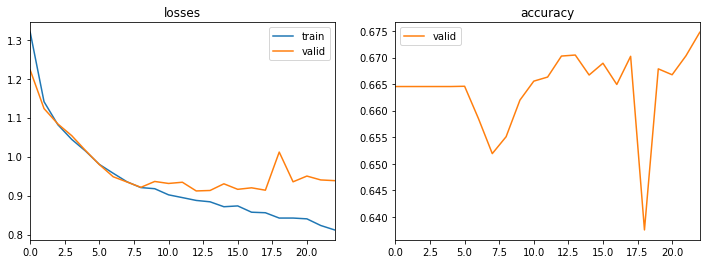

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function RMSProp at 0x000001AE3BEAB1F8>, 'patience': 5, 'time_steps': 30, 'use_bn': True}
MLP                                                                                                                    
 10%|████▉                                            | 3/30 [02:55<22:33, 50.14s/trial, best loss: 0.9382954239845276]

epoch,train_loss,valid_loss,accuracy,time
0,1.770227,22.810177,0.491193,00:01
1,1.165372,1.140220,0.664543,00:01
2,1.133924,1.152482,0.664543,00:01
3,1.133390,1.146978,0.664543,00:01
4,43.259201,1.245442,0.664543,00:01
5,1.608428,29.294270,0.664495,00:01
6,1.145389,75.217766,0.664447,00:01


No improvement since epoch 1: early stopping                                                                           
 10%|████▉                                            | 3/30 [03:07<22:33, 50.14s/trial, best loss: 0.9382954239845276]

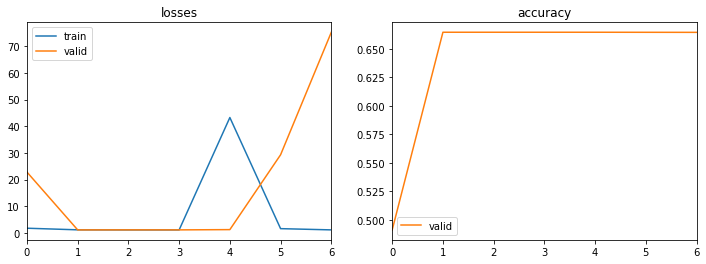

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function RMSProp at 0x000001AE3BEAB1F8>, 'patience': 10, 'time_steps': 60, 'use_bn': False}
MLP                                                                                                                    
 13%|██████▌                                          | 4/30 [03:35<20:25, 47.13s/trial, best loss: 0.9382954239845276]

epoch,train_loss,valid_loss,accuracy,time
0,0.994623,0.976974,0.655567,00:01
1,0.931937,0.966534,0.659572,00:01
2,0.916682,0.973575,0.655229,00:01
3,0.902437,0.975365,0.658800,00:01
4,0.893294,0.971398,0.666329,00:01
5,0.876049,0.934377,0.670817,00:01
6,0.866368,0.999451,0.665026,00:01
7,0.845646,0.986492,0.678249,00:01
8,0.822538,0.933489,0.680180,00:01
9,0.806558,0.985964,0.659958,00:01


No improvement since epoch 8: early stopping                                                                           
 13%|██████▌                                          | 4/30 [03:54<20:25, 47.13s/trial, best loss: 0.9382954239845276]

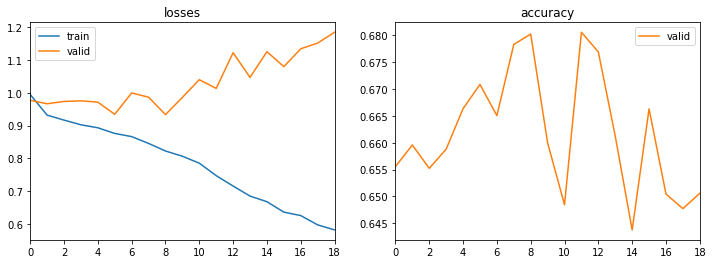

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function RMSProp at 0x000001AE3BEAB1F8>, 'patience': 10, 'time_steps': 60, 'use_bn': False}
MLP                                                                                                                    
 17%|████████▏                                        | 5/30 [04:23<19:42, 47.28s/trial, best loss: 0.9382954239845276]

epoch,train_loss,valid_loss,accuracy,time
0,1.062224,1.079957,0.664543,00:02
1,0.960061,0.961588,0.661599,00:02
2,0.933728,0.935365,0.667535,00:02
3,0.915567,0.930640,0.670045,00:02
4,0.904292,0.929753,0.671203,00:02
5,0.878499,0.931810,0.668259,00:02
6,0.864183,0.926304,0.671300,00:02
7,0.858685,0.941233,0.666425,00:02
8,0.855910,0.992545,0.648038,00:02
9,0.845503,0.943334,0.670286,00:02


No improvement since epoch 12: early stopping                                                                          
 17%|████████▏                                        | 5/30 [05:23<19:42, 47.28s/trial, best loss: 0.9382954239845276]

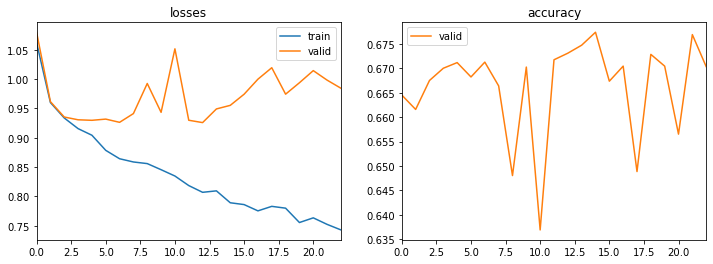

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 10, 'time_steps': 30, 'use_bn': False}
MLP                                                                                                                    
 20%|█████████▊                                       | 6/30 [05:51<23:50, 59.60s/trial, best loss: 0.9382954239845276]

epoch,train_loss,valid_loss,accuracy,time
0,1.786480,1.775059,0.306742,00:00
1,1.780232,1.768127,0.385985,00:00
2,1.771930,1.759156,0.469427,00:00
3,1.760716,1.747216,0.559963,00:00
4,1.746072,1.731467,0.632547,00:00
5,1.727065,1.711184,0.664012,00:00
6,1.702753,1.685756,0.664543,00:00
7,1.673342,1.654634,0.664543,00:00
8,1.637645,1.617283,0.664543,00:00
9,1.595930,1.573190,0.664543,00:00


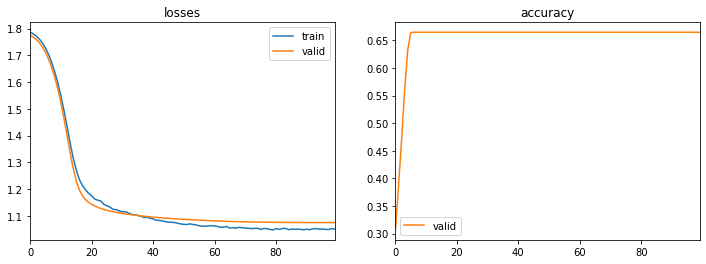

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.0001, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 23%|███████████▍                                     | 7/30 [07:46<29:11, 76.17s/trial, best loss: 0.9382954239845276]

epoch,train_loss,valid_loss,accuracy,time
0,1.444125,1.199816,0.664543,00:01
1,1.054538,0.956655,0.656435,00:01
2,0.907314,0.897933,0.672699,00:01
3,0.862049,0.880102,0.675016,00:01
4,0.837690,0.878974,0.675788,00:01
5,0.814549,0.878318,0.678008,00:01
6,0.797251,0.874861,0.680469,00:01
7,0.784868,0.887926,0.674485,00:01
8,0.782133,0.879161,0.678683,00:01
9,0.777530,0.881419,0.679649,00:01


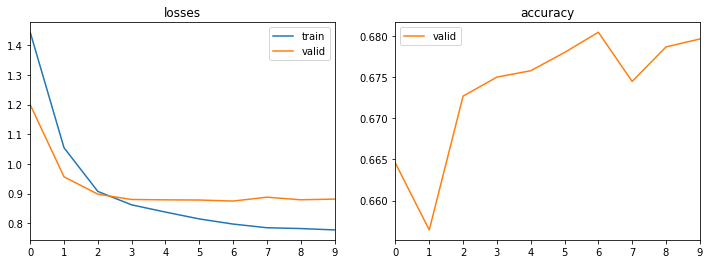

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 27%|█████████████                                    | 8/30 [08:26<23:58, 65.40s/trial, best loss: 0.8814187049865723]

epoch,train_loss,valid_loss,accuracy,time
0,1.061138,1.077726,0.664543,00:02
1,0.920550,0.914901,0.656098,00:02
2,0.874878,0.910376,0.671927,00:02
3,0.852035,0.907432,0.670576,00:02
4,0.831398,0.864072,0.685150,00:02
5,0.801794,0.887060,0.683172,00:02
6,0.804258,0.899480,0.681145,00:02
7,0.777739,0.930276,0.667487,00:02
8,0.761665,0.894732,0.687563,00:02
9,0.756207,0.914971,0.681917,00:02


No improvement since epoch 4: early stopping                                                                           
 27%|█████████████                                    | 8/30 [08:54<23:58, 65.40s/trial, best loss: 0.8814187049865723]

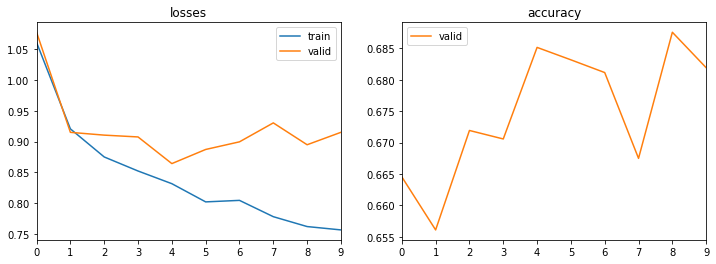

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 30%|██████████████▋                                  | 9/30 [09:22<21:56, 62.68s/trial, best loss: 0.8814187049865723]

epoch,train_loss,valid_loss,accuracy,time
0,1.417275,1.238573,0.664543,00:01
1,1.179221,1.121703,0.664543,00:01
2,1.089591,1.081072,0.664543,00:01
3,1.036852,1.036617,0.664543,00:01
4,0.991144,0.980433,0.656677,00:01
5,0.939579,0.931049,0.646735,00:01
6,0.906669,0.917815,0.649100,00:01
7,0.890599,0.930756,0.656870,00:01
8,0.880725,0.948307,0.653492,00:01
9,0.882728,0.891612,0.672554,00:01


No improvement since epoch 14: early stopping                                                                          
 30%|██████████████▋                                  | 9/30 [09:43<21:56, 62.68s/trial, best loss: 0.8814187049865723]

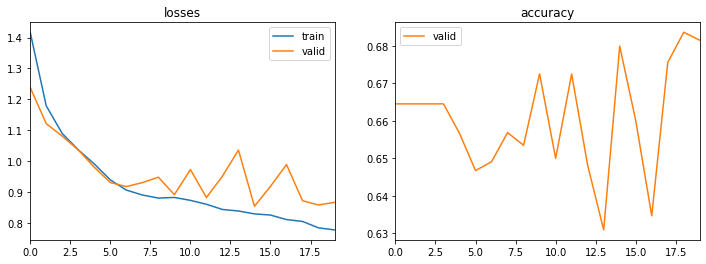

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 10, 'time_steps': 60, 'use_bn': False}
MLP                                                                                                                    
 33%|████████████████                                | 10/30 [10:11<19:31, 58.58s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.010187,0.994538,0.659186,00:01
1,0.923251,0.929247,0.668404,00:01
2,0.883217,0.914051,0.671251,00:01
3,0.847410,0.946329,0.661310,00:01
4,0.812713,0.916156,0.674485,00:01
5,0.778197,0.985382,0.671155,00:01
6,0.755205,1.008158,0.666715,00:01
7,0.732363,1.047394,0.660731,00:01
8,0.706102,1.057876,0.660200,00:01
9,0.691684,1.072165,0.655712,00:01


No improvement since epoch 2: early stopping                                                                           
 33%|████████████████                                | 10/30 [10:34<19:31, 58.58s/trial, best loss: 0.8669081926345825]

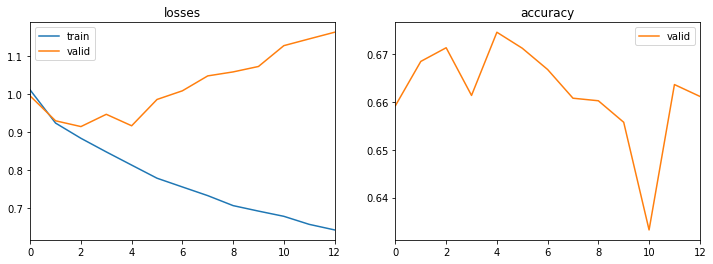

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.0001, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 10, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 37%|█████████████████▌                              | 11/30 [11:04<17:46, 56.15s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.692550,1.644610,0.651996,00:01
1,1.437450,1.373698,0.664543,00:01
2,1.260604,1.232104,0.664543,00:01
3,1.156529,1.140019,0.664543,00:01
4,1.079737,1.091615,0.664543,00:01
5,1.016662,1.038716,0.664302,00:01
6,0.966052,0.971277,0.658173,00:02
7,0.923571,0.926029,0.655760,00:01
8,0.894771,0.907789,0.659186,00:01
9,0.883435,0.904051,0.664398,00:01


No improvement since epoch 19: early stopping                                                                          
 37%|█████████████████▌                              | 11/30 [11:57<17:46, 56.15s/trial, best loss: 0.8669081926345825]

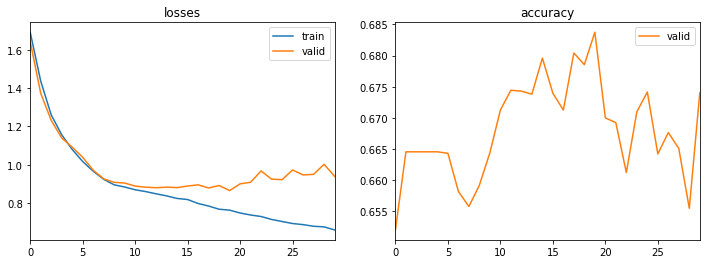

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.0001, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 10, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 40%|███████████████████▏                            | 12/30 [12:27<19:17, 64.31s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.816337,1.822021,0.040587,00:01
1,1.815353,1.821015,0.040490,00:01
2,1.813669,1.819236,0.040442,00:01
3,1.810894,1.816367,0.040490,00:01
4,1.807020,1.812173,0.040635,00:01
5,1.802057,1.806508,0.041118,00:01
6,1.795308,1.799341,0.041890,00:01
7,1.787136,1.790751,0.044351,00:01
8,1.777475,1.780884,0.064572,00:01
9,1.767216,1.769985,0.134791,00:01


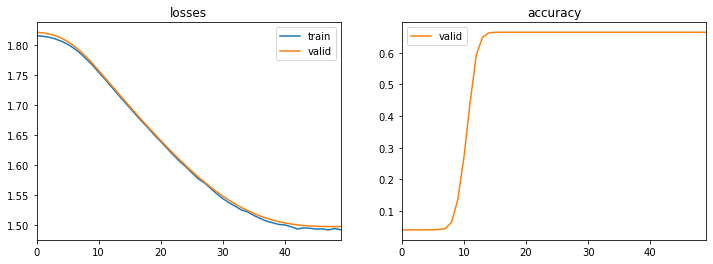

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.0001, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 10, 'time_steps': 30, 'use_bn': False}
MLP                                                                                                                    
 43%|████████████████████▊                           | 13/30 [14:11<21:46, 76.83s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.806126,1.812400,0.065393,00:01
1,1.800800,1.805168,0.066792,00:01
2,1.790125,1.794447,0.069784,00:01
3,1.779788,1.784121,0.076251,00:01
4,1.770531,1.775172,0.090922,00:01
5,1.763433,1.768183,0.113315,00:01
6,1.757946,1.763402,0.135804,00:01
7,1.755337,1.760718,0.150572,00:01
8,1.753875,1.759671,0.156411,00:01
9,1.753553,1.759517,0.157714,00:01


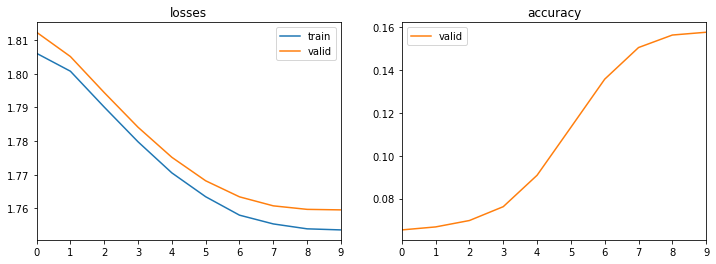

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.01, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 10, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 47%|██████████████████████▍                         | 14/30 [14:51<17:35, 65.97s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.760305,1.748051,0.521934,00:01
1,1.679751,1.663795,0.664543,00:01
2,1.566552,1.541428,0.664543,00:01
3,1.398531,1.362793,0.664543,00:01
4,1.255783,1.230809,0.664543,00:01
5,1.198818,1.176696,0.664543,00:01
6,1.143783,1.139138,0.664543,00:01
7,1.110716,1.111046,0.664543,00:01
8,1.076996,1.089442,0.664543,00:01
9,1.055537,1.070903,0.664543,00:01


No improvement since epoch 31: early stopping                                                                          
 47%|██████████████████████▍                         | 14/30 [15:55<17:35, 65.97s/trial, best loss: 0.8669081926345825]

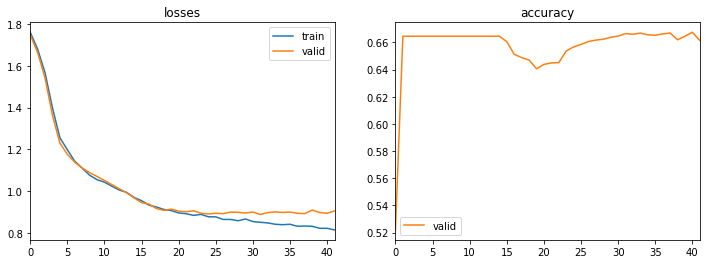

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x000001AE3BEAB1F8>, 'patience': 10, 'time_steps': 30, 'use_bn': False}
MLP                                                                                                                    
 50%|████████████████████████                        | 15/30 [16:23<18:24, 73.66s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.823967,1.813633,0.129482,00:00
1,1.777203,1.749374,0.215723,00:00
2,1.668788,1.591134,0.558322,00:00
3,1.454795,1.340173,0.653009,00:00
4,1.278841,1.206823,0.656387,00:00
5,1.163196,1.131621,0.651272,00:00
6,1.094825,1.092452,0.652140,00:00
7,1.044658,1.045691,0.658221,00:00
8,1.011299,1.012292,0.659186,00:00
9,0.990870,0.995979,0.657883,00:00


No improvement since epoch 25: early stopping                                                                          
 50%|████████████████████████                        | 15/30 [16:56<18:24, 73.66s/trial, best loss: 0.8669081926345825]

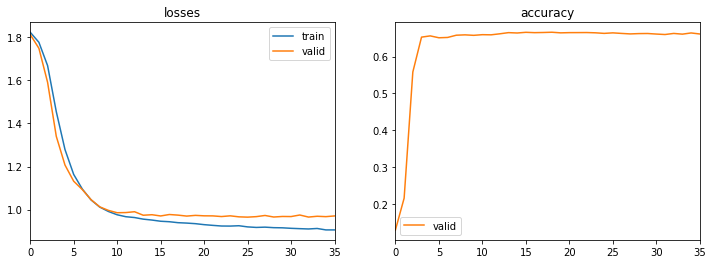

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 53%|█████████████████████████▌                      | 16/30 [17:24<16:15, 69.70s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.026396,0.964523,0.664543,00:01
1,1.117667,1.140170,0.664543,00:01
2,1.133807,1.152363,0.664543,00:01
3,1.134068,1.148157,0.664543,00:01
4,1.138692,1.150280,0.664543,00:01
5,1.138640,1.150684,0.664543,00:01


No improvement since epoch 0: early stopping                                                                           
 53%|█████████████████████████▌                      | 16/30 [17:31<16:15, 69.70s/trial, best loss: 0.8669081926345825]

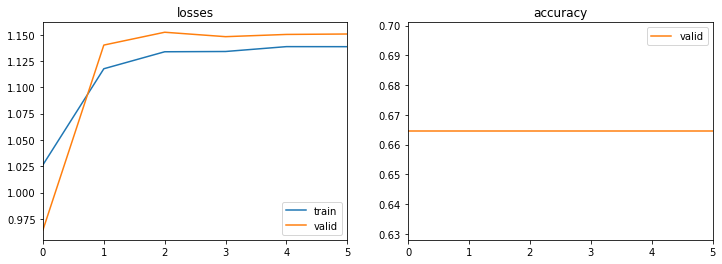

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 10, 'time_steps': 30, 'use_bn': True}
MLP                                                                                                                    
 57%|███████████████████████████▏                    | 17/30 [17:59<12:50, 59.24s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.770435,1.736088,0.244197,00:02
1,1.374581,1.375846,0.658849,00:02
2,1.192145,1.210432,0.664543,00:02
3,1.130064,1.156420,0.664543,00:02
4,1.114920,1.129733,0.664495,00:02
5,1.101099,1.116163,0.664205,00:02
6,1.090680,1.108997,0.663868,00:02
7,1.082738,1.100726,0.663433,00:02
8,1.077918,1.100443,0.663481,00:02
9,1.087194,1.100102,0.663385,00:02


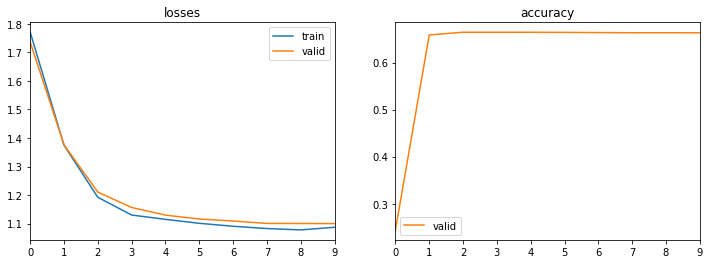

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x000001AE3BEAB1F8>, 'patience': 5, 'time_steps': 60, 'use_bn': False}
MLP                                                                                                                    
 60%|████████████████████████████▊                   | 18/30 [18:51<11:27, 57.25s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.761878,1.712821,0.570243,00:01
1,1.587360,1.477381,0.663626,00:01
2,1.342194,1.248845,0.664543,00:01
3,1.181309,1.138303,0.664350,00:01
4,1.082757,1.084196,0.658511,00:01
5,1.008841,1.016149,0.659331,00:01
6,0.951680,0.971506,0.663868,00:01
7,0.926581,0.928220,0.667584,00:01
8,0.909997,0.928270,0.670672,00:01
9,0.897966,0.904247,0.675112,00:01


No improvement since epoch 12: early stopping                                                                          
 60%|████████████████████████████▊                   | 18/30 [19:09<11:27, 57.25s/trial, best loss: 0.8669081926345825]

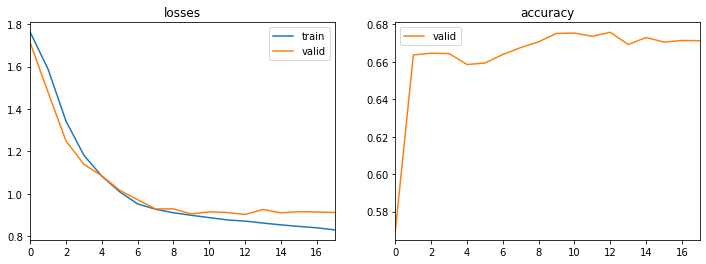

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 10, 'time_steps': 30, 'use_bn': False}
MLP                                                                                                                    
 63%|██████████████████████████████▍                 | 19/30 [19:37<09:53, 53.94s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.067924,0.997296,0.661165,00:01
1,0.962483,0.972296,0.671734,00:01
2,0.939917,0.969114,0.671927,00:01
3,0.909177,0.964365,0.672651,00:01
4,0.879697,0.979825,0.673375,00:01
5,0.864551,1.003055,0.663868,00:01
6,0.844006,0.996740,0.666763,00:01
7,0.820287,0.994708,0.669514,00:01
8,0.810865,0.990598,0.667584,00:01
9,0.807506,0.996656,0.667294,00:01


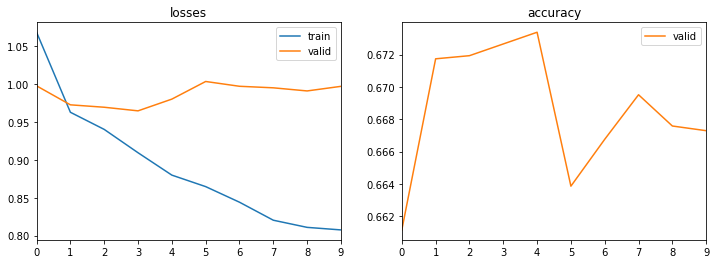

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': True}
MLP                                                                                                                    
 67%|████████████████████████████████                | 20/30 [20:20<08:27, 50.71s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,0.917081,0.890115,0.676415,00:01
1,0.885229,0.898132,0.682737,00:01
2,0.838267,1.024678,0.676608,00:01
3,0.785465,1.004559,0.686405,00:01
4,0.738788,1.092017,0.671396,00:01
5,0.699020,1.079939,0.684571,00:01


No improvement since epoch 0: early stopping                                                                           
 67%|████████████████████████████████                | 20/30 [20:28<08:27, 50.71s/trial, best loss: 0.8669081926345825]

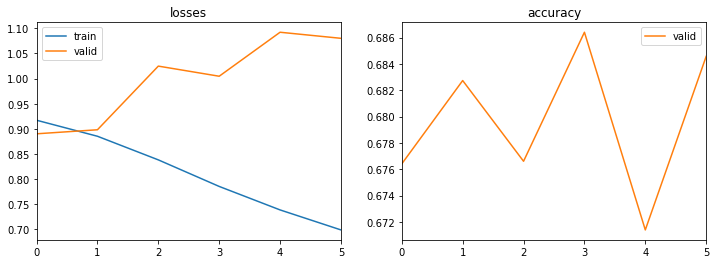

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': True}
MLP                                                                                                                    
 70%|█████████████████████████████████▌              | 21/30 [20:55<06:54, 46.02s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,0.940087,0.896730,0.669755,00:01
1,0.930895,0.993847,0.661020,00:01
2,1.624064,1.145977,0.664543,00:01
3,1.181885,356.129761,0.664398,00:01
4,1.168045,1.155306,0.664543,00:01
5,1.140688,13.187630,0.664495,00:01


No improvement since epoch 0: early stopping                                                                           
 70%|█████████████████████████████████▌              | 21/30 [21:03<06:54, 46.02s/trial, best loss: 0.8669081926345825]

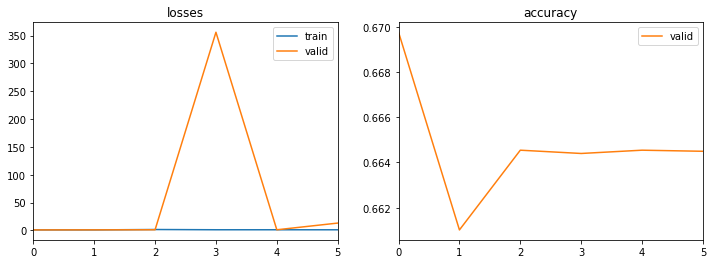

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 73%|███████████████████████████████████▏            | 22/30 [21:30<05:41, 42.75s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,0.976305,0.928540,0.669562,00:01
1,0.915244,0.932884,0.652816,00:01
2,0.923324,0.955242,0.664543,00:01
3,0.970690,1.009945,0.664543,00:01
4,1.112988,1.146699,0.664543,00:01
5,1.132954,1.151859,0.664543,00:01


No improvement since epoch 0: early stopping                                                                           
 73%|███████████████████████████████████▏            | 22/30 [21:37<05:41, 42.75s/trial, best loss: 0.8669081926345825]

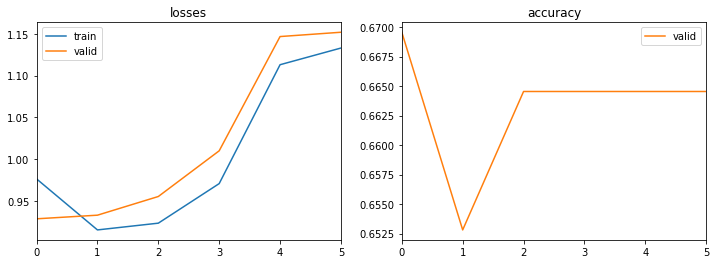

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 77%|████████████████████████████████████▊           | 23/30 [22:05<04:41, 40.22s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.705789,1.599881,0.664543,00:01
1,1.283644,1.145802,0.664543,00:01
2,1.128149,1.101758,0.664543,00:01
3,1.075064,1.082096,0.664543,00:01
4,1.049154,1.068497,0.664543,00:01
5,1.034939,1.057652,0.664543,00:01
6,1.023140,1.048631,0.664543,00:01
7,1.019098,1.043817,0.664543,00:01
8,1.013595,1.041984,0.664543,00:01
9,1.009820,1.041819,0.664543,00:01


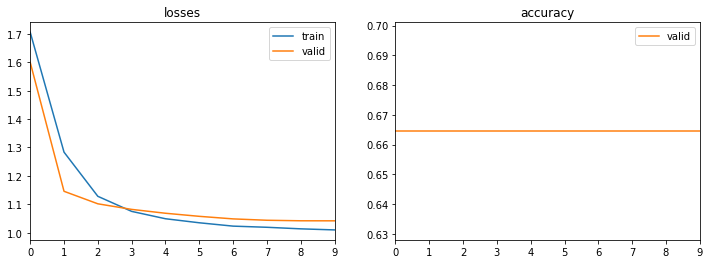

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.0001, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': True}
MLP                                                                                                                    
 80%|██████████████████████████████████████▍         | 24/30 [22:44<03:58, 39.72s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.308544,1.280430,0.621978,00:03
1,1.078664,1.056488,0.654071,00:03
2,0.972979,0.962113,0.658221,00:03
3,0.909139,0.921745,0.668838,00:03
4,0.879234,0.873125,0.679166,00:03
5,0.845295,0.888843,0.681193,00:03
6,0.816116,0.894638,0.676270,00:03
7,0.786963,0.918116,0.664929,00:03
8,0.749572,0.909919,0.676850,00:03
9,0.735225,0.982843,0.671589,00:03


No improvement since epoch 4: early stopping                                                                           
 80%|██████████████████████████████████████▍         | 24/30 [23:18<03:58, 39.72s/trial, best loss: 0.8669081926345825]

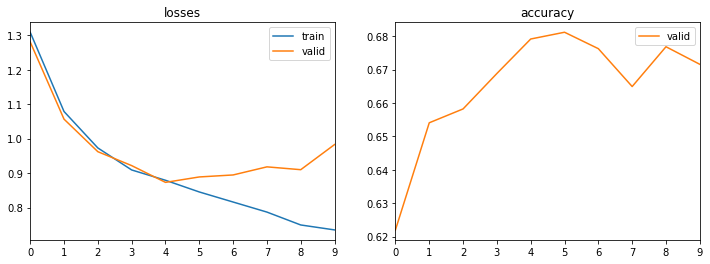

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 83%|████████████████████████████████████████        | 25/30 [23:45<03:51, 46.35s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.391852,1.232956,0.664543,00:01
1,1.175418,1.125335,0.664543,00:01
2,1.091146,1.085812,0.664543,00:01
3,1.042595,1.045702,0.664543,00:01
4,0.995909,0.989314,0.659476,00:01
5,0.941041,0.926149,0.649196,00:01
6,0.909107,0.961845,0.637035,00:01
7,0.894759,0.981555,0.643357,00:01
8,0.885883,0.920474,0.664833,00:01
9,0.882596,0.897122,0.671058,00:01


No improvement since epoch 19: early stopping                                                                          
 83%|████████████████████████████████████████        | 25/30 [24:12<03:51, 46.35s/trial, best loss: 0.8669081926345825]

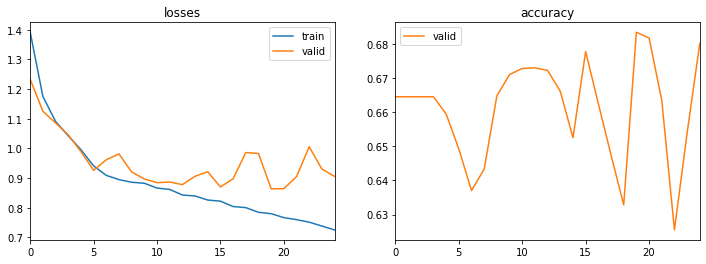

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 87%|█████████████████████████████████████████▌      | 26/30 [24:40<03:15, 48.80s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.670754,1.557109,0.664543,00:01
1,1.273909,1.153109,0.664543,00:01
2,1.131165,1.104615,0.664543,00:01
3,1.076345,1.081903,0.664543,00:01
4,1.053108,1.065223,0.664543,00:01
5,1.042948,1.054880,0.664543,00:01
6,1.023728,1.045444,0.664543,00:01
7,1.026560,1.041119,0.664543,00:01
8,1.023849,1.039333,0.664543,00:01
9,1.020925,1.039014,0.664543,00:01


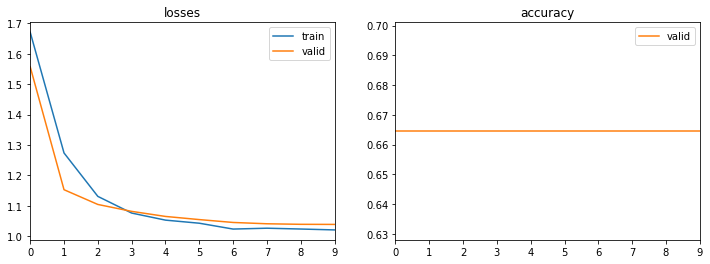

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.0001, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 90%|███████████████████████████████████████████▏    | 27/30 [25:18<02:17, 45.72s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.448517,1.193116,0.664543,00:01
1,1.053637,0.957964,0.656629,00:01
2,0.910725,0.894381,0.670093,00:01
3,0.863282,0.880030,0.678442,00:01
4,0.838914,0.878563,0.676415,00:01
5,0.820254,0.890821,0.671589,00:01
6,0.802926,0.892220,0.673664,00:01
7,0.791702,0.878851,0.677380,00:01
8,0.785270,0.881991,0.675498,00:01
9,0.783403,0.878621,0.676463,00:01


No improvement since epoch 4: early stopping                                                                           
 90%|███████████████████████████████████████████▏    | 27/30 [25:30<02:17, 45.72s/trial, best loss: 0.8669081926345825]

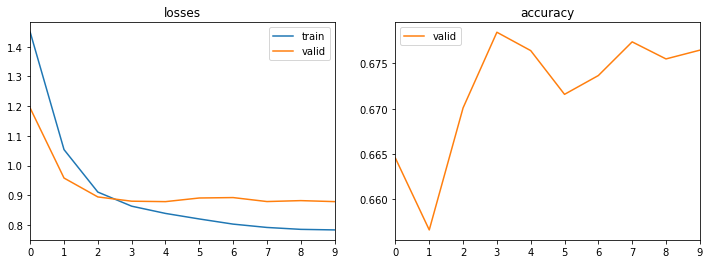

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001AE3BEAB438>, 'patience': 5, 'time_steps': 90, 'use_bn': True}
MLP                                                                                                                    
 93%|████████████████████████████████████████████▊   | 28/30 [25:58<01:27, 43.86s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,0.898732,0.907788,0.675981,00:01
1,0.843159,0.964010,0.674581,00:01
2,0.830061,1.012446,0.671444,00:01
3,0.802071,0.955102,0.671107,00:01
4,0.794895,0.991401,0.678056,00:01
5,0.795747,0.933059,0.689494,00:01


No improvement since epoch 0: early stopping                                                                           
 93%|████████████████████████████████████████████▊   | 28/30 [26:06<01:27, 43.86s/trial, best loss: 0.8669081926345825]

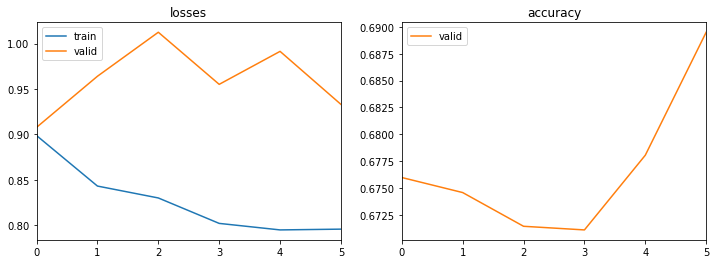

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.0001, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP                                                                                                                    
 97%|██████████████████████████████████████████████▍ | 29/30 [26:33<00:41, 41.32s/trial, best loss: 0.8669081926345825]

epoch,train_loss,valid_loss,accuracy,time
0,1.774194,1.773906,0.168476,00:02
1,1.770449,1.769693,0.221563,00:02
2,1.764132,1.762263,0.330196,00:02
3,1.750615,1.750331,0.514309,00:02
4,1.733827,1.732974,0.647073,00:02
5,1.711316,1.709637,0.664302,00:02
6,1.678271,1.680042,0.664543,00:02
7,1.642063,1.644228,0.664543,00:02
8,1.601998,1.602481,0.664543,00:02
9,1.553516,1.555279,0.664543,00:02


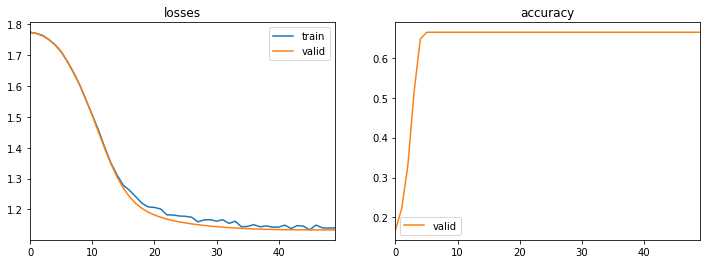

100%|████████████████████████████████████████████████| 30/30 [28:35<00:00, 57.19s/trial, best loss: 0.8669081926345825]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 2, 'epochs': 1, 'fc_dropout': 1, 'layers': 2, 'lr': 0, 'optimizer': 1, 'patience': 0, 'ts': 2, 'use_bn': 1}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 5, 'time_steps': 90, 'use_bn': False}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = MLP
    k = {
        'layers': params['layers'],
        'fc_dropout': params['fc_dropout'],
        'use_bn': params['use_bn']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 1024, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function SGD at 0x000001AE3BEAB0D8>, 'patience': 5, 'time_steps': 90, 'use_bn': False}
MLP


epoch,train_loss,valid_loss,accuracy,time
0,1.431147,1.260212,0.664543,00:01
1,1.185897,1.130035,0.664543,00:01
2,1.097121,1.088270,0.664543,00:01
3,1.045552,1.049523,0.664543,00:01
4,1.001155,0.992006,0.662902,00:01
5,0.949390,0.930729,0.647218,00:01
6,0.909633,0.897110,0.652285,00:01
7,0.900338,0.883530,0.669418,00:01
8,0.891310,0.884573,0.671010,00:01
9,0.882301,0.959877,0.663047,00:01


No improvement since epoch 16: early stopping


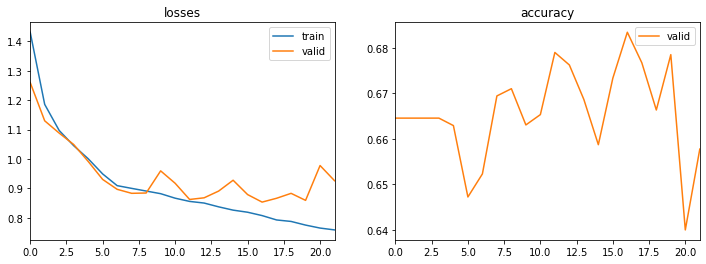

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[3.0506e-01, 3.1572e-01, 2.3049e-01, 1.2914e-01, 1.8278e-02, 1.3099e-03],
         [9.3555e-01, 4.3048e-02, 1.9089e-02, 2.1362e-03, 1.5291e-04, 1.9422e-05],
         [9.3153e-01, 5.1521e-02, 1.4602e-02, 2.1987e-03, 1.3411e-04, 1.0108e-05],
         ...,
         [9.9656e-01, 3.0235e-03, 3.9458e-04, 2.5633e-05, 2.5524e-07, 1.1977e-08],
         [9.9927e-01, 6.8445e-04, 4.1128e-05, 1.4056e-06, 3.7842e-09, 9.4135e-11],
         [9.8695e-01, 1.1689e-02, 1.2905e-03, 6.5616e-05, 5.7352e-07, 1.8017e-08]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([1, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.710954
f1 score:   0.691675


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_MLP', y_test_true)
np.save('y_pred_MLP', y_test_pred)